<a href="https://colab.research.google.com/github/lukegriffiths/daylight_hours/blob/master/daylight_hours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import numpy as np
import requests
import lxml.html as lh
import pandas as pd
from matplotlib import pyplot as plt

In [0]:
def make_dataframe_from_tr_elements(tr_elements):
  """
  Make a Pandas DataFrame from table elements
  Adapted from https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
  """

  # get column names
  col=[]
  i=0 #For each row, store each first element (header) and an empty list
  for t in tr_elements[0]:
      i+=1
      name=t.text_content()
      #print("{} {}".format(i,name))
      col.append((name,[]))

  # get data
  for j in range(1,len(tr_elements)):
      T = tr_elements[j]
      i=0 # column index initiated at 0
      for t in T.iterchildren():
        data=t.text_content() 
        #if i>0: 
        data = str(data)
        col[i][1].append(data)
        i+=1
  Dict = {title:column for (title,column) in col}
  df = pd.DataFrame(Dict)

  return df

def get_table_elements_from_url(url):
  """
  Make a Pandas DataFrame from table elements
  Adapted from https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
  """
  print("Getting data from: {}".format(url))
  page = requests.get(url)
  doc = lh.fromstring(page.content) # store contents of the website
  tr_elements = doc.xpath('//tr') # Parse all data that are stored between <tr>..</tr> of HTML, here that is 3 tables (sunrise, sunset, midday)
  print("Total number of table elements: {}".format(len(tr_elements)))
  return tr_elements

def get_sunrise_sunset_df_from_lat_long_year(latitude, longitude, year):
  url = "https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat={}&lon={}&year={}".format(latitude, longitude, year)
  tr_elements = get_table_elements_from_url(url)
  tr_sunrise_elements = tr_elements[:32] # sunrise table: 32 elements = 1 header row + 31 days
  tr_sunset_elements = tr_elements[32:64] # sunset table: 32 elements = 1 header row + 31 days
  df_sunrise = make_dataframe_from_tr_elements(tr_sunrise_elements)
  df_sunset = make_dataframe_from_tr_elements(tr_sunset_elements)
  return df_sunrise, df_sunset


In [226]:
# Logitude and latitude from https://www.gps-latitude-longitude.com/gps-coordinates-of-oslo 
# URL can be generalised to: https://www.gps-latitude-longitude.com/gps-coordinates-of-TOWN_NAME
# Longitude of Oslo: 10.7522454
# Latitude of Oslo: 59.9138688
# Longitude of Plogoff: -4.666499
# Latitude of Plogoff: 48.036674
# Longitude of Strasbourg: 7.7521113
# Latitude of Strasbourg: 48.5734053

year = 2020

df_sunrise_oslo, df_sunset_oslo = get_sunrise_sunset_df_from_lat_long_year(latitude=59.9138688, longitude=10.7522454, year=year)
df_sunrise_plogoff, df_sunset_plogoff = get_sunrise_sunset_df_from_lat_long_year(latitude=48.036674, longitude=-4.666499, year=year)
df_sunrise_strasbourg, df_sunset_strasbourg = get_sunrise_sunset_df_from_lat_long_year(latitude=48.5734053, longitude=7.7521113, year=year)


Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=59.9138688&lon=10.7522454&year=2020
Total number of table elements: 96
Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=48.036674&lon=-4.666499&year=2020
Total number of table elements: 96
Getting data from: https://www.esrl.noaa.gov/gmd/grad/solcalc/table.php?lat=48.5734053&lon=7.7521113&year=2020
Total number of table elements: 96


In [0]:
# Get array from each dataframe 
def get_1d_array_of_times_from_df(times_df):
  month_columns = times_df.columns[1:] # list of the month column names
  times_df = times_df[month_columns].apply(pd.to_datetime, format='%H:%M', errors='coerce') # from string to datetime
  #times_df = times_df[month_columns].apply(pd.to_timedelta, errors='coerce') # from string to timedelta
  times_array = times_df.values.transpose().reshape(-1,1) # make into long array of times
  times_array = times_array[~np.isnan(times_array)] # remove all NaTs
  return times_array

sunrise_oslo = get_1d_array_of_times_from_df(df_sunrise_oslo)
sunset_oslo = get_1d_array_of_times_from_df(df_sunset_oslo)

sunrise_strasbourg = get_1d_array_of_times_from_df(df_sunrise_strasbourg)
sunset_strasbourg = get_1d_array_of_times_from_df(df_sunset_strasbourg)

sunrise_plogoff = get_1d_array_of_times_from_df(df_sunrise_plogoff)
sunset_plogoff = get_1d_array_of_times_from_df(df_sunset_plogoff)


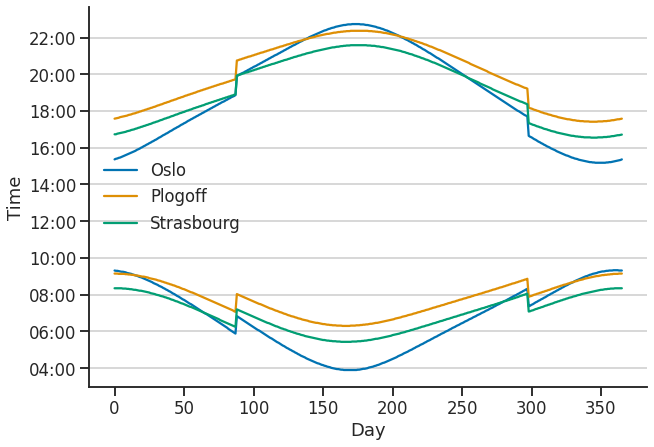

In [255]:
# Plot figure
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk') # makes fonts and lines thicker
cmap = sns.color_palette('colorblind')

f, ax = plt.subplots(figsize=(10,7))
# Oslo
ax.plot(sunrise_oslo, color=cmap[0])
ax.plot(sunset_oslo, label='Oslo', color=cmap[0])
# Plogoff
ax.plot(sunrise_plogoff, color=cmap[1])
ax.plot(sunset_plogoff, label='Plogoff', color=cmap[1])
# Strasbourg
ax.plot(sunrise_strasbourg, color=cmap[2])
ax.plot(sunset_strasbourg, label='Strasbourg', color=cmap[2])

ax.set_ylabel('Time')
ax.set_xlabel('Day')
myFmt = mdates.DateFormatter('%H:%M')
ax.yaxis.set_major_formatter(myFmt)
ax.grid(axis='y')
#ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
sns.despine() # does same as line above
ax.legend(ncol=1, loc='center left', frameon=False)
plt.show()
